# Post-Processing Visualization

## Imports

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

LABEL = 'category'
INPUT = 'title'

data = pd.read_csv('./data/data_preprocessed_out.csv') 

## Word Distribution

In [6]:
def plot_frequency_distribution_of_ngrams(sample_texts,
                    ngram_range=(1, 1),
                    num_ngrams=50):

    # Create args for vectorizer
    kwargs = {
        'ngram_range': ngram_range,
        'dtype': 'int32',
        'strip_accents': 'unicode',
        'decode_error': 'replace',
        'analyzer': 'word',  # Split text into word tokens.
    }
    # Tokenize each text using CountVectorizer
    vectorizer = CountVectorizer(**kwargs)

    # Create document-term matrix
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # Get the sum of each word's frequency
    all_ngrams = list(vectorizer.get_feature_names())
    
    # Select the most least wanted frequent ngrams
    num_ngrams = min(num_ngrams, len(all_ngrams))
    
    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True
    )])
    ngrams = list(all_ngrams[:num_ngrams])
    counts = list(all_counts[:num_ngrams])

    idx = np.arange(num_ngrams)
    plt.figure(figsize=(24, 12))
    plt.bar(idx, counts, color='b')
    plt.xlabel('N-gram')
    plt.ylabel('Frequency')
    plt.title('Frequency distribution of n-grams')
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()

def get_num_words_per_sample(sample_texts):
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)


c:\Users\Tenessine\.conda\envs\Pleiades\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


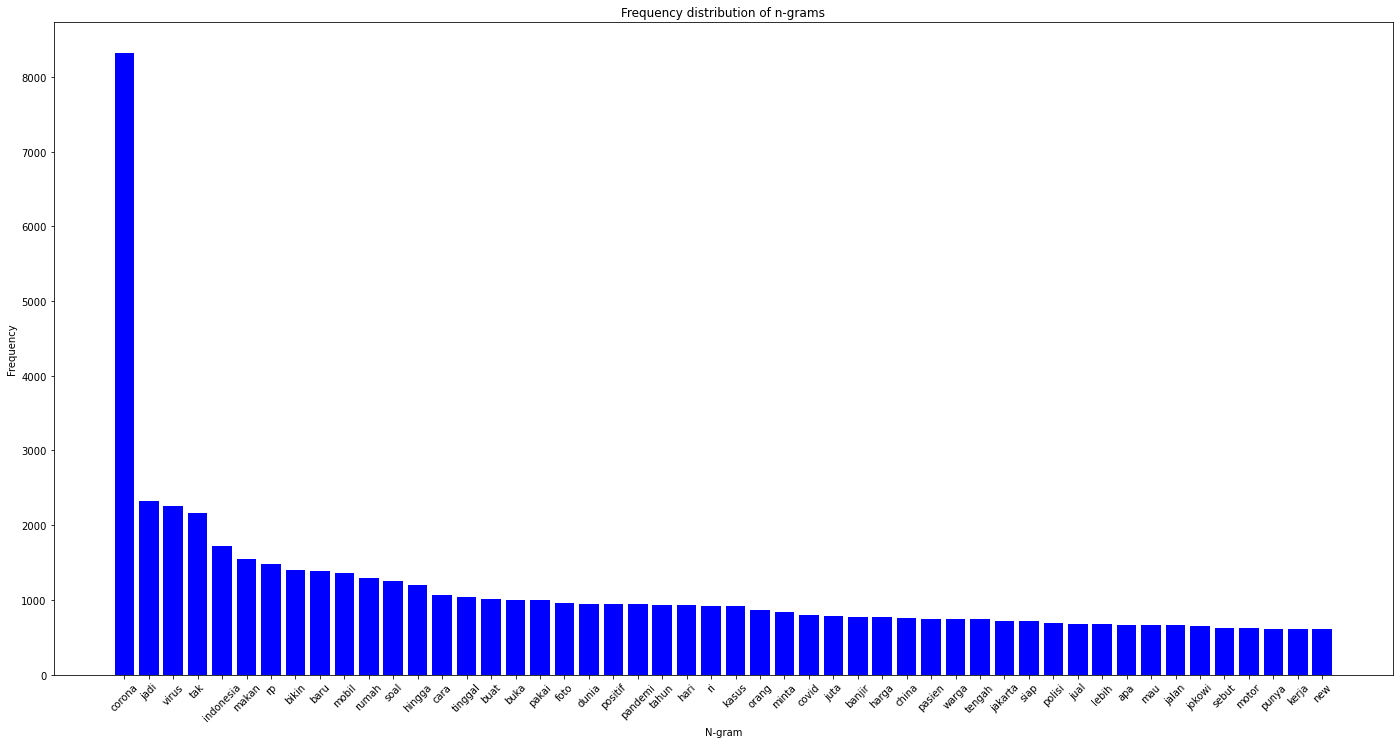

Median number of words per sample: 8.0


In [7]:
plot_frequency_distribution_of_ngrams(data[INPUT])
print('Median number of words per sample: {}'.format(
    get_num_words_per_sample(data[INPUT])
))

# Feature Extraction

## Imports

In [26]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing import text

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

## Hyperparameters

In [8]:
NGRAM_RANGE = (1, 2)

TOP_K = 20000

TOKEN_MODE = 'word'

MIN_DOCUMENT_FREQUENCY = 2

MAX_SEQUENCE_LENGTH = 500

## Ngram Vectorizer

In [9]:
from sklearn.feature_selection import f_classif


def ngram_vectorize(train_texts, train_labels, val_texts):

    kwargs = {
        'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
        'dtype': 'int32',
        'strip_accents': 'unicode',
        'decode_error': 'replace',
        'analyzer': TOKEN_MODE,  # Split text into word tokens.
        'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train)
    x_val = selector.transform(x_val)

    x_train = x_train.astype('float32')
    x_val = x_val.astype('float32')

    return x_train.toarray(), x_val.toarray()

# Modelling

## Imports

In [10]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras import models
from tensorflow.keras import initializers
from tensorflow.keras import regularizers

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

## Last Layer Decision

In [11]:
def _get_last_layer_units_and_activation(num_classes):
    if num_classes == 2:
        units = 1
        activation = 'sigmoid'
    else:
        units = num_classes
        activation = 'softmax'
    return units, activation

## Multi-Layer Perceptron Model

In [12]:
def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    model.add(
        Dropout(rate=dropout_rate, input_shape=input_shape)
    )

    for _ in range(0, layers):
        model.add(
            Dense(units=units, activation='relu')
        )
        model.add(
            Dropout(rate=dropout_rate)
        )
    
    model.add(
        Dense(units=op_units, activation=op_activation)
    )

    return model

# Training

## Data Splitting

In [45]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    data[INPUT], data[LABEL], test_size=0.2, random_state=42
)

splitted_data = ((train_texts.tolist(), np.array(train_labels.tolist())), (val_texts.tolist(), np.array(val_labels.tolist())))


## Train MLP Model

In [43]:
def train_mlp_model(data,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=2,
                      units=64,
                      dropout_rate=0.2):

    # Unpack data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
    num_classes = len(np.unique(train_labels))
    unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError('Unexpected label values found in the validation set:'
                         ' {unexpected_labels}. Please make sure that the '
                         'labels in the validation set are in the same range '
                         'as training labels.'.format(unexpected_labels=unexpected_labels))
    # Vectorize texts.
    x_train, x_val = ngram_vectorize(
        train_texts=train_texts,
        train_labels=train_labels,
        val_texts=val_texts,
    )
    
    # Create model instance.
    model = mlp_model(
        layers=layers,
        units=units,
        dropout_rate=dropout_rate,
        input_shape=x_train.shape[1:],
        num_classes=num_classes,
    )

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
        )
    ]

    # Train and validate model.
    history = model.fit(
        x_train,
        train_labels,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=(x_val, val_labels),
        verbose=2,
        batch_size=batch_size,
    )
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
        acc=history['val_accuracy'][-1],
        loss=history['val_loss'][-1]
    ))

    # Save model.
    model.save('ngram_model.h5')
    return model, history['val_accuracy'][-1], history['val_loss'][-1]


In [46]:
trained_mlp_model, accuracy, loss = train_mlp_model(
    data=splitted_data,
    epochs=10,
)

c:\Users\Tenessine\.conda\envs\Pleiades\lib\site-packages\sklearn\feature_extraction\text.py:2029: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(


Epoch 1/10
277/277 - 9s - loss: 1.5088 - accuracy: 0.5461 - val_loss: 0.6805 - val_accuracy: 0.8051
Epoch 2/10
277/277 - 8s - loss: 0.6046 - accuracy: 0.8191 - val_loss: 0.5412 - val_accuracy: 0.8318
Epoch 3/10
277/277 - 8s - loss: 0.4439 - accuracy: 0.8626 - val_loss: 0.5239 - val_accuracy: 0.8348
Epoch 4/10
277/277 - 8s - loss: 0.3695 - accuracy: 0.8826 - val_loss: 0.5275 - val_accuracy: 0.8375
Epoch 5/10
277/277 - 8s - loss: 0.3195 - accuracy: 0.8958 - val_loss: 0.5435 - val_accuracy: 0.8337
Validation accuracy: 0.8336911201477051, loss: 0.5434660911560059


In [48]:
trained_mlp_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_3 (Dropout)          (None, 20000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                1280064   
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 9)                 585       
Total params: 1,284,809
Trainable params: 1,284,809
Non-trainable params: 0
____________________________________________